In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt

# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz


## Utility Functions

In [2]:
# General mathematical Functions
def percent(val, total):
    return round(100 * val/total, 2)
    
# General Dataframe functions
def listColumsWithMissingData(df):
    naCols = len(df.columns[df.isna().any()])
    print(f"Columns with missing data: {naCols} {percent(naCols, len(df.columns))}%")
    [print(f"{col:30}  {df[col].isna().sum(): 7d} {percent(df[col].isna().sum(),df.shape[0])}%") for col in df.columns if df[col].isna().any() ]

def getGeneralInfo(df):
    print(df.info());print()
    getCategoricalValues(df);print()
    listColumsWithMissingData(df);print()

def getCategoricalValues(df):
    cat_columns = df.select_dtypes(include=['object']).columns.tolist()
    cat_columns.sort()
    print(f"Columns with categorical values {len(cat_columns)} --> {cat_columns}")
    for col in cat_columns:
        count_values = df[col].unique().shape[0]
        print(f"{col:27} : [{count_values:2}]", end=' ')
        if count_values < 10:
            print(f"--> {sorted((df[col].unique().tolist())) if np.NaN not in df[col].unique().tolist() else (df[col].unique().tolist())}", end=' ')
        print()

def ConvertClassToNumLabel(df, col):
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(df[col].unique().tolist())
    class_to_label = dict(zip(le.classes_, labels))
    print(class_to_label)
    return df[col].map(class_to_label) 
       

In [3]:
def groupByAndCount(df, col, sort = True, skipPercent=True):
    total_rows = df.shape[0]
    df_ = df.groupby(by=col).agg({col:"count"})
    df_.rename(columns={col:'Count'}, inplace=True)
    df_.reset_index(inplace=True)
    if sort == True: df_.sort_values(by='Count', ascending=False, inplace=True)
    if not skipPercent:
        df_['%'] = round((df_['Count']/total_rows)*100,2)
    return df_

def groupPerTarget(df, col):
    df_1 = df[df['Exited']==1][[col,'Exited']]
    cnt_1 = df_1.shape[0]
    df_1 = groupByAndCount(df_1, col, sort = False)
    df_1.rename(columns={'Count':'Exited=1'},inplace=True)

    df_0 = df[df['Exited']==0][[ col,'Exited']]
    cnt_0 = df_0.shape[0]
    df_0 = groupByAndCount(df_0, col, sort = False)
    df_0.rename(columns={'Count':'Exited=0'},inplace=True)

    df_ = df_0.merge(df_1, how='left',on=col)
    if df_.isna().sum().sum() > 0:
        df_.fillna(0, inplace=True)
    df_['Total'] = df_['Exited=0'] + df_['Exited=1']
    df_['Exited=0%'] = percent(df_['Exited=0'], df_['Total']) 
    df_['Exited=1%'] = percent(df_['Exited=1'], df_['Total'])
    df_.set_index(col, inplace=True)

    df_= df_[['Total', 'Exited=1', 'Exited=0', 'Exited=1%', 'Exited=0%' ]]

    print(f"df_1: {cnt_1}, df_0: {cnt_0}")
    print(df_)
    
    return df_

def plotTargetWiseBarPlots(df, col, title, labels=[], figsize=(15, 6)):
    df_ = groupPerTarget(df, col)
    ax = df_[['Exited=0%','Exited=1%']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize); annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Exited - %age values")
    #plt.show()

In [4]:
def plotBar(df, title, w=10, h=10, logy=False):
    plt.figure(figsize=(w, h), dpi=80)
    ax = df.plot.bar(logy=logy) 
    # Annotate
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)
    plt.show()

def annotate(ax, title='', strformat='', divideby=1):
    # Annotate
    for p in ax.patches:
        # format(, '.1f')
        value = p.get_height()/divideby
        ax.annotate(f"{value:.1f}{strformat}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)

def plotScatter(df, col1, col2, title, pos=1, log=False):
    plt.subplot(1, 2, pos)
    ax = df.plot.scatter(col1, col2,figsize=(10, 6))
    if log == True: ax.set_xscale('log')
    ax.set_title(title)
    plt.show()

from graphviz import Source
def get_dt_graph(dt_classifier, X):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True, feature_names=X.columns, class_names=['Exited', 'Not Exited'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.set_size('"15,25!"')
    return graph.create_png()

In [5]:
def evaluate_model(dt_classifier, category, X, y):
    print(f"{category} Accuracy : {percent(accuracy_score(y, dt_classifier.predict(X)), 1)}%")
    print(f"{category} Confusion Matrix:")
    print(confusion_matrix(y, dt_classifier.predict(X)))

# Calculate & print VIF
def getVIF(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    print(vif)

from sklearn import metrics
def confusionmatrix(y_train, col_actual, col_predicted):
    confusion = confusion_matrix(y_train[col_actual], y_train[col_predicted])
    print("Confusion Matrix:\n", confusion)

    # Let's look at other metrices, Sensitivity Specificity
    TP, TN,FP, FN  = confusion[1,1], confusion[0,0], confusion[0,1], confusion[1,0] # false negativies
    sensitivity = TP/float (TP+FN)
    specificity = TN/float (TN+FP)
    fpr = FP/float(TN+FP)
    ppv = TP/float(TP+FP)

    print(f"Accuracy: {round(100 * accuracy_score(y_train[col_actual],y_train[col_predicted]),2)}% "
          f"Sensitivity: {round(sensitivity*100,2)}% Specificity: {round(specificity*100,2)}% FPR: {round(fpr*100,2)}% PPV: {round(ppv*100,2)}%")

def draw_roc (actual,probs):
    fpr,tpr,thresholds = metrics.roc_curve (actual,probs,drop_intermediate = False)
    auc_score = metrics.roc_auc_score (actual,probs)
    plt.figure (figsize =(5,5))
    plt.figure()
    plt.plot(fpr, tpr, label = 'ROC Curve(area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - Lead Score')
    plt.legend(loc="lower right")
    plt.show()
    
    return None

def predict(model, X, y):
    y_pred = model.predict(X)
    #print(y_pred [:5])
    #print((y_pred*100).astype(int)[:5])

    y_pred = y_pred.values.reshape(-1)
    #print(y_pred[:5])

    y_pred_final = pd.DataFrame ({'Actual': y.values, 'Prob' : y_pred})
    y_pred_final['ID'] = y.index
    #print(y_pred_final.head())

    y_pred_final['Predicted'] = y_pred_final['Prob'].map(lambda x: 1 if x>0.5 else 0)

    ## LOOK at the head of the data
    print(y_pred_final.head())
    return y_pred_final

## Read data and perform first checks

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data/Churn_Modelling.csv")
getGeneralInfo(df)

Mounted at /content/gdrive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None

Columns with categorical values 3 --> ['Gender', 'Geography',

**Findings**:
- **Exited** is the target variable. 
    - 1 --> There was a churn. 
    - 0 --> There was no churn. 
- Is the dataset is balanced or imbalanced?
- From the name, features RowNumber, CustomerId seem to have unique values. 
- From the name, features HasCrCard, IsActiveMember seem to be boolean variables.

Let's check

In [7]:
# Check if RowNumber, CustomerId have unique values?
print('RowNumber', df[df['RowNumber'].duplicated()].shape[0])
print('CustomerId', df[df['CustomerId'].duplicated()].shape[0])

RowNumber 0
CustomerId 0


In [8]:
# Check if HasCrCard, IsActiveMember are boolean variables?
print(f"HasCrCard:\n{df['HasCrCard'].value_counts()}"); print()
print(f"IsActiveMember:\n{df['IsActiveMember'].value_counts()}")

HasCrCard:
1    7055
0    2945
Name: HasCrCard, dtype: int64

IsActiveMember:
1    5151
0    4849
Name: IsActiveMember, dtype: int64


0    79.63
1    20.37
Name: Exited, dtype: float64


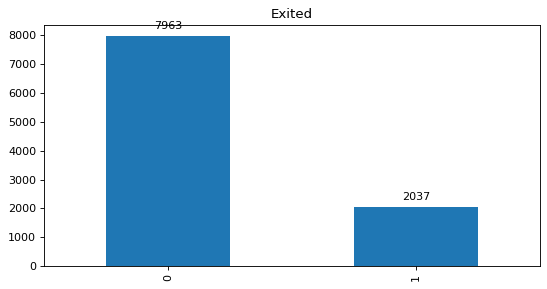

In [9]:
# Is the dataset is balanced or imbalanced wrt the target variable?
print(df['Exited'].value_counts(normalize=True)*100)
plotBar(df['Exited'].value_counts(), 'Exited', w=8, h=4)

**Findings**
- Columns RowNumber, CustomerId have unique values (identifiers). So these can be removed.
- Column Surname is only an identifier. So this can also be removed.
- Columns HasCrCard, IsActiveMember are boolean variables.
- None of the columns have missing values. No imputation of missing values is required
- The dataset is imbalanced wrt the target variable. 

In [10]:
df.drop(columns=['RowNumber', 'CustomerId','Surname'], inplace=True)
getGeneralInfo(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB
None

Columns with categorical values 2 --> ['Gender', 'Geography']
Gender                      : [ 2] --> ['Female', 'Male'] 
Geography                   : [ 3] --> ['France', 'Germany', 'Spain'] 

Columns with missing data: 0 0.

Now the identifier columns have been dropped.

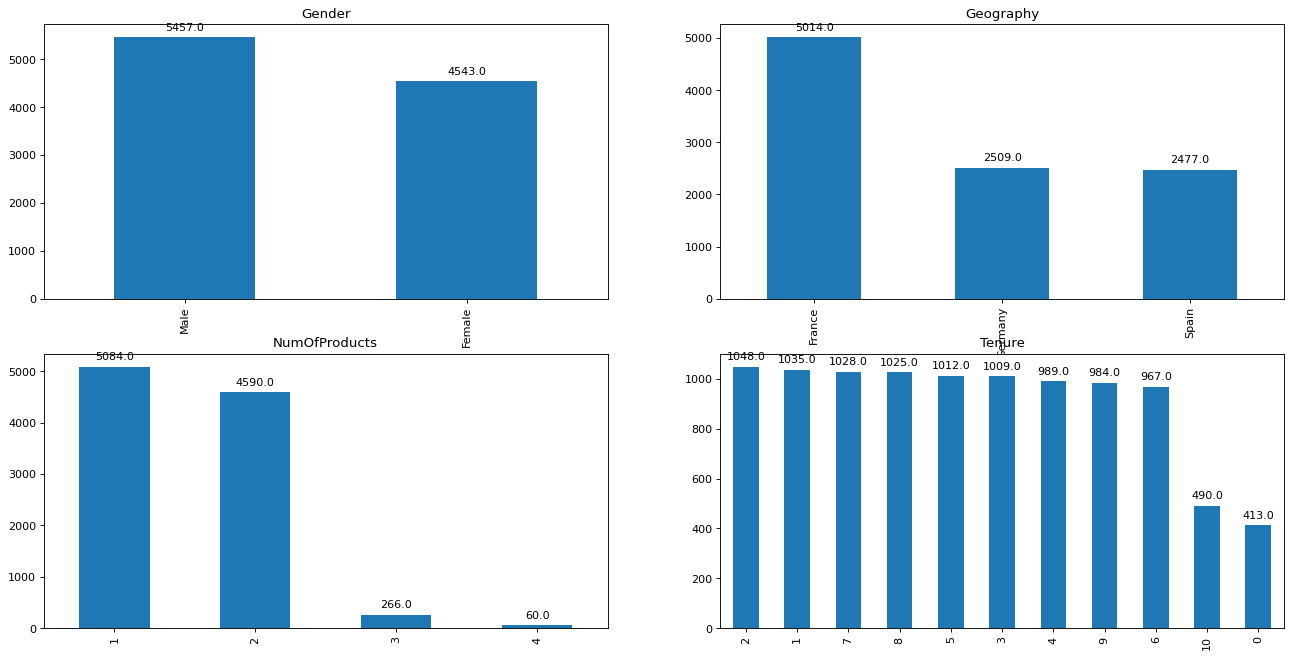

In [11]:
plt.figure(dpi=80, figsize=(20, 10))

plt.subplot(2, 2, 1); ax = df['Gender'].value_counts().plot.bar(); annotate(ax=ax, title='Gender')
plt.subplot(2, 2, 2); ax = df['Geography'].value_counts().plot.bar(); annotate(ax=ax, title='Geography')
plt.subplot(2, 2, 3); ax = df['NumOfProducts'].value_counts().plot.bar(); annotate(ax=ax, title='NumOfProducts')
plt.subplot(2, 2, 4); ax = df['Tenure'].value_counts().plot.bar(); annotate(ax=ax, title='Tenure')

**Findings**
- Most customers are from France
- Most customers have either 1 or 2 products

df_1: 2037, df_0: 7963
        Total  Exited=1  Exited=0  Exited=1%  Exited=0%
Gender                                                 
Female   4543      1139      3404      25.07      74.93
Male     5457       898      4559      16.46      83.54
df_1: 2037, df_0: 7963
           Total  Exited=1  Exited=0  Exited=1%  Exited=0%
Geography                                                 
France      5014       810      4204      16.15      83.85
Germany     2509       814      1695      32.44      67.56
Spain       2477       413      2064      16.67      83.33
df_1: 2037, df_0: 7963
               Total  Exited=1  Exited=0  Exited=1%  Exited=0%
NumOfProducts                                                 
1               5084      1409      3675      27.71      72.29
2               4590       348      4242       7.58      92.42
3                266       220        46      82.71      17.29
df_1: 2037, df_0: 7963
        Total  Exited=1  Exited=0  Exited=1%  Exited=0%
Tenure            

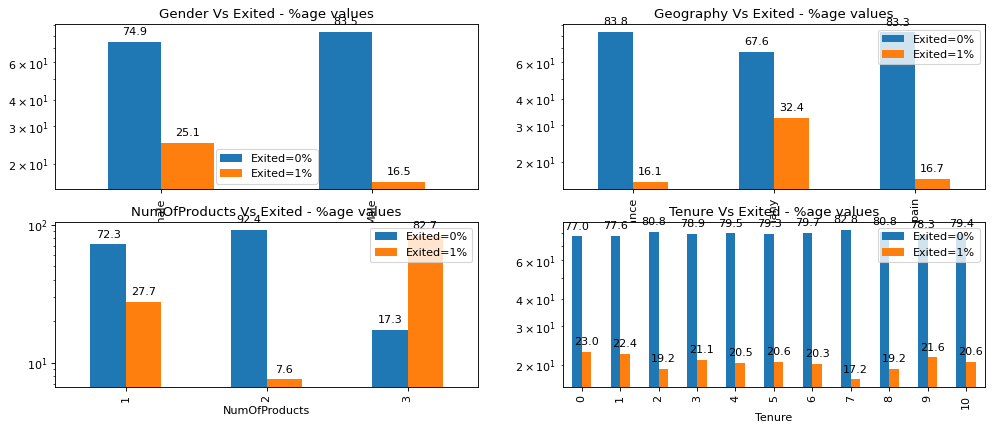

In [12]:
plt.figure(dpi=80, figsize=(30, 20))

plt.subplot(2, 2, 1); plotTargetWiseBarPlots(df, 'Gender', 'Gender')
plt.subplot(2, 2, 2); plotTargetWiseBarPlots(df, 'Geography', 'Geography')
plt.subplot(2, 2, 3); plotTargetWiseBarPlots(df, 'NumOfProducts', 'NumOfProducts')
plt.subplot(2, 2, 4); plotTargetWiseBarPlots(df, 'Tenure', 'Tenure')

Findings:
- Compared to Males, less female customers have exited
- More percentage of the customers from Germany have exited
- Customers with 3 products tend to exit followed by the customers with 1 product. Customers with 2 products tend to be mroe stable.


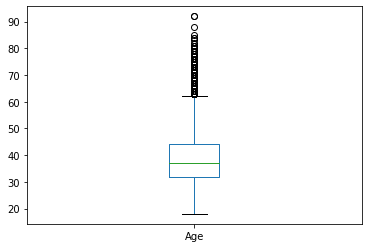

In [13]:
df['Age'].plot.box()

In [14]:
# Let's add a new column "Age group"
#age_group = pd.cut(df.Age,bins=[0,18,30, 40,60,99],labels=['0-18','18-30', '30-40','40-60','60-99'])
#df['Age group'] =  age_group
#df

In [15]:
#plotTargetWiseBarPlots(df, 'Age group', 'Age group')

**Findings**:
- Customers in the age group 40 to 60 tend to exit compared to the rest of the age groups

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

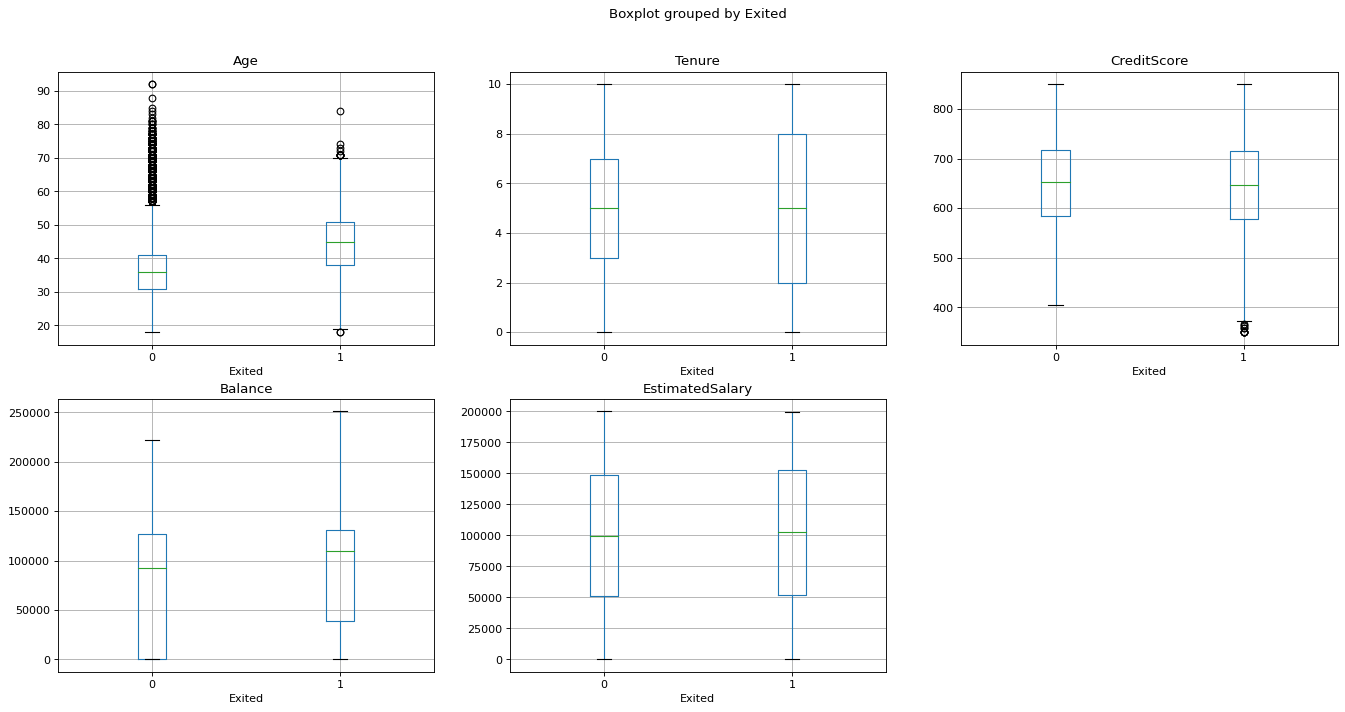

In [16]:
plt.figure(dpi=80, figsize=(20, 10))

ax = plt.subplot(2, 3, 1); df.boxplot('Age', by='Exited', ax=ax)
ax = plt.subplot(2, 3, 2); df.boxplot('Tenure', by='Exited', ax=ax)
ax = plt.subplot(2, 3, 3); df.boxplot('CreditScore', by='Exited', ax=ax)
ax = plt.subplot(2, 3, 4); df.boxplot('Balance', by='Exited', ax=ax)
ax = plt.subplot(2, 3, 5); df.boxplot('EstimatedSalary', by='Exited', ax=ax)

df_1: 2037, df_0: 7963
        Total  Exited=1  Exited=0  Exited=1%  Exited=0%
Tenure                                                 
0         413        95       318      23.00      77.00
1        1035       232       803      22.42      77.58
2        1048       201       847      19.18      80.82
3        1009       213       796      21.11      78.89
4         989       203       786      20.53      79.47
5        1012       209       803      20.65      79.35
6         967       196       771      20.27      79.73
7        1028       177       851      17.22      82.78
8        1025       197       828      19.22      80.78
9         984       213       771      21.65      78.35
10        490       101       389      20.61      79.39


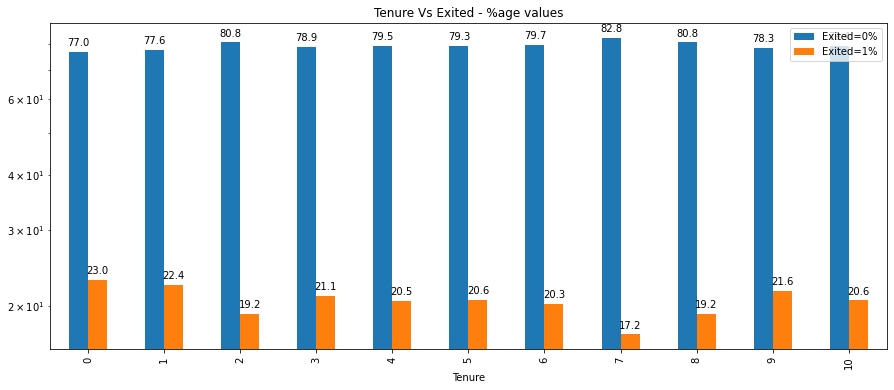

In [17]:
plotTargetWiseBarPlots(df, 'Tenure', 'Tenure')

**Findings**:
- Customers in the age group 50 to 70 are more likely to exit
- Customers with balance in the range 225000 and 250000 tend to exit.
- EstimatedSalary distribution for Exited=0 & Exited=1 is similar

In [18]:
# Reorder the columns
df = df[['Age', 'Gender', 'Geography', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Balance', 'NumOfProducts', 'Tenure', 'CreditScore', 'Exited']]#,'Age group']]

# Group the columns for convenience
COLS_NUMERIC = ['Age','EstimatedSalary', 'Balance', 'NumOfProducts', 'Tenure', 'CreditScore'] 
COLS_CATEGORIC = ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember']#, 'Age group']

In [19]:
# Convert the values of categorical variables to numerical labels/codes
for col in COLS_CATEGORIC:
    df[col] = ConvertClassToNumLabel(df, col)

df.head()

{'Female': 0, 'Male': 1}
{'France': 0, 'Germany': 2, 'Spain': 1}
{0: 1, 1: 0}
{0: 1, 1: 0}


,Age,Gender,Geography,HasCrCard,IsActiveMember,EstimatedSalary,Balance,NumOfProducts,Tenure,CreditScore,Exited
0,42,0,0,0,0,101348.88,0.00,1,2,619,1
1,41,0,1,1,0,112542.58,83807.86,1,1,608,0
2,42,0,0,0,1,113931.57,159660.80,3,8,502,1
3,39,0,0,1,1,93826.63,0.00,2,1,699,0
4,43,0,1,0,0,79084.10,125510.82,1,2,850,0


## Split data

Split to train, validate and test sets

In [20]:
X = df.drop(columns=['Exited'])
y = df['Exited']
X.head()

,Age,Gender,Geography,HasCrCard,IsActiveMember,EstimatedSalary,Balance,NumOfProducts,Tenure,CreditScore
0,42,0,0,0,0,101348.88,0.00,1,2,619
1,41,0,1,1,0,112542.58,83807.86,1,1,608
2,42,0,0,0,1,113931.57,159660.80,3,8,502
3,39,0,0,1,1,93826.63,0.00,2,1,699
4,43,0,1,0,0,79084.10,125510.82,1,2,850


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print("TRAIN:", y_train.shape[0],"\n", y_train.value_counts(normalize=True)*100, "\n", sep='')
print("TEST:", y_test.shape[0], "\n", y_test.value_counts(normalize=True)*100, "\n",  sep='')

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

TRAIN:8000
0    79.45
1    20.55
Name: Exited, dtype: float64

TEST:2000
0    80.35
1    19.65
Name: Exited, dtype: float64

X_train: (8000, 10), X_test: (2000, 10)


## Logistic Regression

In [22]:
# Build a Logistic regression model with all the features
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)
logm1 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
logm1.fit().summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Exited   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7989
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3459.2
Date:                Mon, 15 Nov 2021   Deviance:                       6918.4
Time:                        13:18:36   Pearson chi2:                 8.11e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.5166      0.278    -16.263      0.000      -5.061      -3.972
Age                 0.0717      0.003     25.169      0.000       0.066       0.077
Gender             -0.5367      0.061     -8.863      0.000      -0.655      -0.418
Geography           0.3682      0.038      9.761      0.000       0.294       0.442
HasCrCard           0.0173      0.066      0.263      0.793      -0.112       0.146
IsActiveMember      1.0722      0.064     16.722      0.000       0.947       1.198
EstimatedSalary  2.787e-07   5.27e-07      0.529      0.597   -7.54e-07    1.31e-06
Balance           3.07e-06   5.55e-07      5.537      0.000    1.98e-06    4.16e-06
NumOfProducts      -0.0953      0.052     -1.819      0.069      -0.198       0.007
Tenure             -0.0145      0.010     -1.392      0.164      -0.035       0.006
CreditScore        -0.0007      0.000     -2.275      0.023      -0.001   -9.85e-05
===================================================================================
"""

There are features with p-value > 0.05. So let's run RFE to select fewer number of features

In [23]:
# Run Recursive Feature Elimiation to eliminate features
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

lm = LogisticRegression()
rfe = RFE(lm, 6)
rfe = rfe.fit(X_train,y_train)
print(list(zip(X_train.columns, rfe.support_, rfe.ranking_)))
COLS_SELECTED = X_train.columns[rfe.support_].tolist()
print("Columns selected by RFE:", COLS_SELECTED)

[('Age', True, 1), ('Gender', True, 1), ('Geography', True, 1), ('HasCrCard', False, 4), ('IsActiveMember', True, 1), ('EstimatedSalary', False, 5), ('Balance', False, 3), ('NumOfProducts', True, 1), ('Tenure', True, 1), ('CreditScore', False, 2)]
Columns selected by RFE: ['Age', 'Gender', 'Geography', 'IsActiveMember', 'NumOfProducts', 'Tenure']


In [24]:
#COLS_SELECTED.remove('Age group') # This was added explicitly and this is resulting in high VIF value. So removing this
print(X_train_sm.columns)
print(X_train_sm[COLS_SELECTED].columns)
X_train_sm = sm.add_constant(X_train_sm[COLS_SELECTED])
print(X_train_sm.columns)

Index(['const', 'Age', 'Gender', 'Geography', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Balance', 'NumOfProducts', 'Tenure', 'CreditScore'],
      dtype='object')
Index(['Age', 'Gender', 'Geography', 'IsActiveMember', 'NumOfProducts',
       'Tenure'],
      dtype='object')
Index(['const', 'Age', 'Gender', 'Geography', 'IsActiveMember',
       'NumOfProducts', 'Tenure'],
      dtype='object')


In [25]:
# Create a model with the selected features
lr = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Exited   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7993
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3477.4
Date:                Mon, 15 Nov 2021   Deviance:                       6954.8
Time:                        13:18:36   Pearson chi2:                 8.14e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.6386      0.174    -26.693      0.000      -4.979      -4.298
Age                0.0714      0.003     25.136      0.000       0.066       0.077
Gender            -0.5267      0.060     -8.730      0.000      -0.645      -0.408
Geography          0.4468      0.035     12.659      0.000       0.378       0.516
IsActiveMember     1.0758      0.064     16.827      0.000       0.950       1.201
NumOfProducts     -0.1738      0.051     -3.412      0.001      -0.274      -0.074
Tenure            -0.0138      0.010     -1.327      0.184      -0.034       0.007
==================================================================================
"""

In [26]:
getVIF(X_train[COLS_SELECTED])

         Features   VIF
0             Age  7.10
4   NumOfProducts  5.86
5          Tenure  3.64
1          Gender  2.08
3  IsActiveMember  1.85
2       Geography  1.79


In [27]:
y_train_pred_final = predict(lr_model, X_train_sm, y_train )

   Actual      Prob    ID  Predicted
0       0  0.035184  9254          0
1       0  0.157595  1561          0
2       1  0.104833  1670          0
3       1  0.126375  6087          0
4       1  0.403737  6669          0


In [28]:
confusionmatrix(y_train_pred_final, 'Actual', 'Predicted')

Confusion Matrix:
 [[6147  209]
 [1313  331]]
Accuracy: 80.97% Sensitivity: 20.13% Specificity: 96.71% FPR: 3.29% PPV: 61.3%


In [29]:
#evaluate_model(lr_model, "TRAIN", X_train[COLS_SELECTED], y_train);print()
#evaluate_model(lr_model, "TEST", X_test, y_test);print()
#print(classification_report(y_test, lr_model.predict(X_test)))

<Figure size 360x360 with 0 Axes>

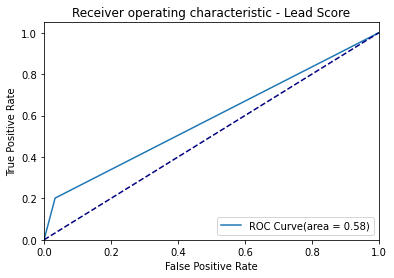

In [30]:
draw_roc(y_train_pred_final['Actual'],y_train_pred_final['Predicted'])

## Decision Tree Classifier w/o Hyperparameter Tuning
Note: For the Churn use-case we would be interested to get a as less a *False Negative* value as possible. In other words, we require a good *Recall* value

The split of train and test across the target variable classes is similar (80-20) so not using stratify = True

In [31]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [32]:
evaluate_model(dt, "TRAIN", X_train, y_train);print()
evaluate_model(dt, "TEST", X_test, y_test);print()
print(classification_report(y_test, dt.predict(X_test)))

TRAIN Accuracy : 84.55%
TRAIN Confusion Matrix:
[[6061  295]
 [ 941  703]]

TEST Accuracy : 84.85%
TEST Confusion Matrix:
[[1527   80]
 [ 223  170]]

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1607
           1       0.68      0.43      0.53       393

    accuracy                           0.85      2000
   macro avg       0.78      0.69      0.72      2000
weighted avg       0.83      0.85      0.83      2000



**Findings**
- The training and test accuracies of 84% are good
- The model has a good recall value of 85% 

In [33]:
# Get the faeture importances
df_fi = pd.DataFrame({
        "variables": X.columns.to_list(),
        "feature importance": dt.feature_importances_})
df_fi.sort_values(by='feature importance', ascending=False).head()

,variables,feature importance
0,Age,0.462755
7,NumOfProducts,0.326011
4,IsActiveMember,0.201143
6,Balance,0.010090
1,Gender,0.000000


Features - Age, Number of products and member activness - are most important.

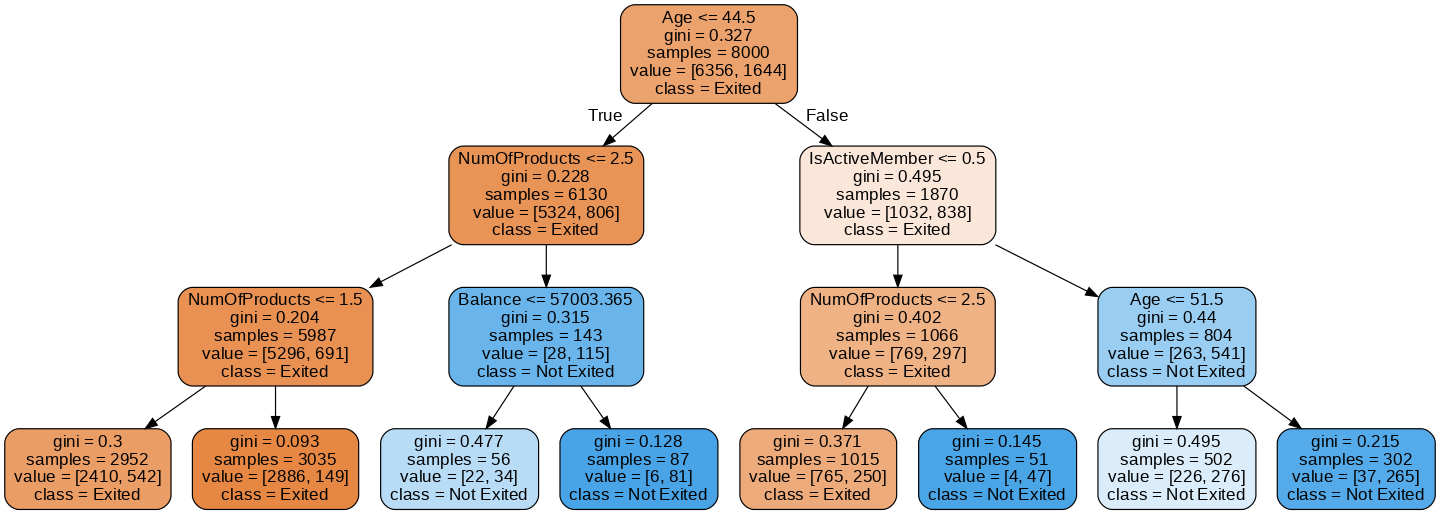

In [34]:
Image(get_dt_graph(dt, X))

### Interpretation of the model: 

Following Customers tend to exit (churn)
- age <=44.5 years and number of products <=2.5 
- age > 44.5, member is not active and the number of products <=2.5 

Following Customers tend to not exit (no churn)
- age <=44.5 years and number of products > 2.5 
- age > 44.5, member is not active but number of products > 2.5 
- age > 44.5, member is active


## Decision Tree Classifier - with hyperparameter tuning

In [35]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 4], #  5, 10] If 5 and 10 are included, the best estimator has depth of 10 and the interpretation of the model was difficult. So using only the values of 2,3 4
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [36]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [37]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 458 ms, sys: 81 ms, total: 539 ms
Wall time: 3.02 s


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.0s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=3,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                        

In [38]:
df_score = pd.DataFrame(grid_search.cv_results_)
df_score.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013113,0.003007,0.002865,0.001102,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.8405,0.8375,0.8405,0.8255,0.836000,0.006185,18
1,0.011701,0.000070,0.002474,0.000071,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.8405,0.8375,0.8405,0.8255,0.836000,0.006185,18
2,0.011735,0.000243,0.002476,0.000188,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.8405,0.8375,0.8405,0.8255,0.836000,0.006185,18
3,0.013315,0.002318,0.002309,0.000231,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.8405,0.8375,0.8405,0.8255,0.836000,0.006185,18
4,0.013408,0.002610,0.002547,0.000166,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.8405,0.8375,0.8405,0.8150,0.833375,0.010679,22


In [39]:
df_score.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
11,0.018663,0.000265,0.002599,0.000147,gini,4,10,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.8530,0.8480,0.8565,0.8405,0.849500,0.006010,1
10,0.023178,0.003743,0.002554,0.000027,gini,4,5,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.8525,0.8480,0.8550,0.8405,0.849000,0.005511,2
12,0.020072,0.001487,0.002349,0.000046,gini,4,20,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.8535,0.8480,0.8550,0.8395,0.849000,0.006072,2
13,0.020114,0.002425,0.002292,0.000062,gini,4,50,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.8515,0.8415,0.8480,0.8415,0.845625,0.004307,4
5,0.017166,0.002689,0.002415,0.000155,gini,3,5,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.8450,0.8450,0.8475,0.8395,0.844250,0.002926,5


In [40]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [41]:
evaluate_model(dt_best, "TRAIN", X_train, y_train);print()
evaluate_model(dt_best, "TEST", X_test, y_test);print()
print(classification_report(y_test, dt_best.predict(X_test)))

TRAIN Accuracy : 85.25%
TRAIN Confusion Matrix:
[[6203  153]
 [1027  617]]

TEST Accuracy : 85.25%
TEST Confusion Matrix:
[[1562   45]
 [ 250  143]]

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1607
           1       0.76      0.36      0.49       393

    accuracy                           0.85      2000
   macro avg       0.81      0.67      0.70      2000
weighted avg       0.84      0.85      0.83      2000



**Findings**
- The model has a good Train and test accuracy values of 85% 
- The model has a good recall value of 85% 

In [42]:
# Get the feature importances
df_fi = pd.DataFrame({
        "variables": X.columns.to_list(),
        "feature importance": dt_best.feature_importances_})
df_fi.sort_values(by='feature importance', ascending=False).head()

,variables,feature importance
0,Age,0.461602
7,NumOfProducts,0.343490
4,IsActiveMember,0.177242
6,Balance,0.015903
8,Tenure,0.001762


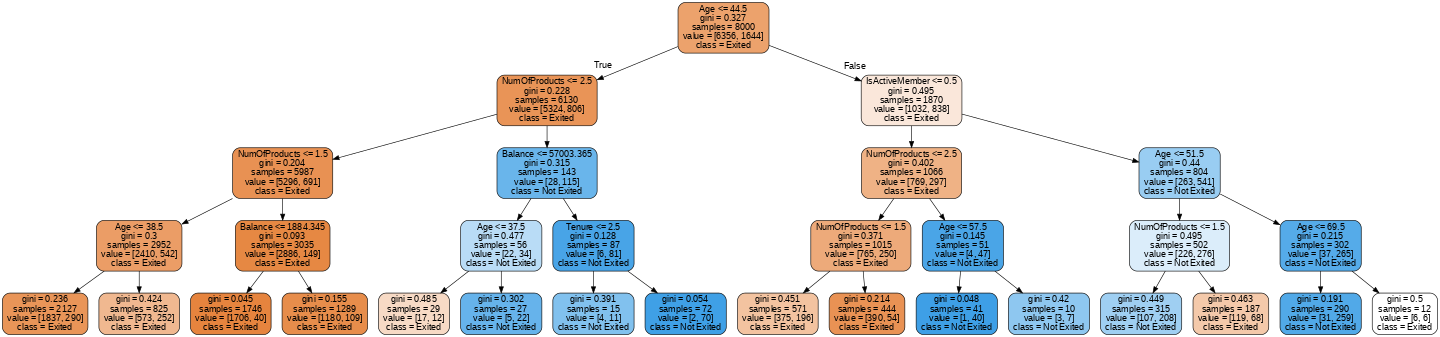

In [43]:
Image(get_dt_graph(dt_best, X))

Following Customers tend to exit (churn)
- age <=44.5 years and number of products <=2.5 
- age > 44.5, member is active but number of products <=2.5 
- age > 44.5 and <51.5, member is not active

## Random Forest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3,oob_score=True)
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4],
    'n_estimators': [10, 30, 50, 100, 200]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")


In [45]:
%%time
grid_search.fit(X,y)

Fitting 4 folds for each of 375 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1258 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  9.9min finished


CPU times: user 15.7 s, sys: 1.32 s, total: 17 s
Wall time: 9min 55s


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=3,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=True, random_state=42,
                                       

In [46]:
rf_best = grid_search.best_estimator_

In [47]:
rf_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [48]:
evaluate_model(rf_best, "TRAIN", X_train, y_train);print()
evaluate_model(rf_best, "TEST", X_test, y_test);print()
print(classification_report(y_test, rf_best.predict(X_test)))

TRAIN Accuracy : 88.96%
TRAIN Confusion Matrix:
[[6245  111]
 [ 772  872]]

TEST Accuracy : 89.45%
TEST Confusion Matrix:
[[1575   32]
 [ 179  214]]

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1607
           1       0.87      0.54      0.67       393

    accuracy                           0.89      2000
   macro avg       0.88      0.76      0.80      2000
weighted avg       0.89      0.89      0.88      2000



- The train and test accuracies are 88% both higher than the decision tree ones. 
- Th recall value 88% is also higher.

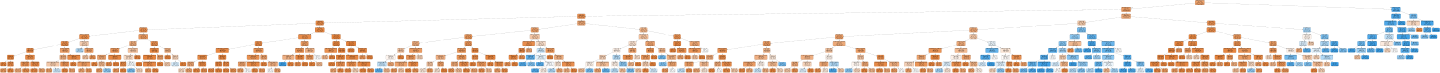

In [49]:
Image(get_dt_graph(rf_best.estimators_[0],X), height=600, width=600)

In [50]:
rf_best.oob_score_*100

86.41

OOB score is good too!

## Summary
| Algorithm | Features | TRAIN Accuracy | TEST Accuracy |
|---|--- |--- |--- |
| Logistic Regression | Age, NumOfProducts, Tenure, Gender, IsActiveMember Geography| | |
| Decision Tree | Age, NumOfProducts, IsActiveMember, Balance, Tenure | 85.25% | 85.25% |
| Random Forest | | 88.96% | 89.45% |


## Use PCA to reduce the number of features

In [51]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
X_scaler = preprocessing.StandardScaler().fit(X_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.values.reshape(-1,1))
Xtrain=X_scaler.transform(X_train) 
ytrain=y_scaler.transform(y_train.values.reshape(-1,1)) 

Xtest=X_scaler.transform(X_test) 
ytest=y_scaler.transform(y_test.values.reshape(-1,1))

In [52]:
pca = PCA(n_components=6,random_state=100)
Xtrain_reduced = pca.fit_transform(X_train)
Xtest_reduced = pca.transform(X_test)

In [55]:
regrpca = LogisticRegression()
# Train the model using the principal components of the transformed training sets
regrpca.fit(Xtrain_reduced, ytrain)
# Make predictions using the principal components of the transformed testing set
y_pred = regrpca.predict(Xtest_reduced)
print("Mean squared error: %.2f" % mean_squared_error(ytest, y_pred))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(ytest, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: ignored